 # 简易Darcy-Flow数据集示例

 本示例介绍neuralop库中内置的小型Darcy-Flow数据集的使用方法。

 Darcy-Flow（达西流）问题是流体力学中基础的偏微分方程（PDE）， 用于描述流体在多孔介质中的流动规律。本教程将展示数据集的结构， 并可视化神经网络算子（Neural Operator）训练前的数据处理过程。



In [7]:
# 导入绘图库matplotlib（用于数据可视化）
import matplotlib.pyplot as plt
# 从neuralop数据模块导入小型Darcy-Flow数据集加载函数
from neuralop.data.datasets import load_darcy_flow_small
# 从neuralop层模块导入2D网格位置嵌入层（用于给输入数据添加空间位置信息）
from neuralop.layers.embeddings import GridEmbedding2D


 ## 加载数据集

 训练集样本的分辨率为16x16；测试集同时加载16x16和32x32两种分辨率的样本， 用于验证模型的“分辨率不变性”（即模型在不同分辨率下的泛化能力）。


In [8]:
# 加载小型Darcy-Flow数据集
# 参数说明：
#   n_train: 训练集样本数量（20个）
#   batch_size: 训练集批次大小（每次加载4个样本）
#   test_resolutions: 测试集的分辨率列表（16x16和32x32）
#   n_tests: 对应不同分辨率测试集的样本数量（各10个）
#   test_batch_sizes: 对应不同分辨率测试集的批次大小（16x16批次4个，32x32批次2个）
# 返回值：
#   train_loader: 训练集数据加载器（可迭代的批次数据）
#   test_loaders: 测试集数据加载器字典（key为分辨率，value为对应加载器）
#   data_processor: 数据处理器（用于数据预处理，如归一化、添加维度等）
train_loader, test_loaders, data_processor = load_darcy_flow_small(
    n_train=20,
    batch_size=4,
    test_resolutions=[16, 32],
    n_tests=[10, 10],
    test_batch_sizes=[4, 2],
)

# 从训练集加载器中提取完整的训练数据集（方便按索引访问单个样本）
train_dataset = train_loader.dataset


Loading test db for resolution 16 with 10 samples 
Loading test db for resolution 32 with 10 samples 


 ## 可视化数据结构

 查看不同分辨率下测试集样本的形状，以及训练集样本的基础形状，理解输入（x）和输出（y）的数据维度。

iter(test_loader) 返回一个迭代器，每次迭代返回一个批次的数据。 每个批次的数据是一个字典，包含输入张量 `x` 和输出张量 `y`。 其中，输入张量 `x` 的形状为 `(batch_size, 1, 分辨率, 分辨率)`， 输出张量 `y` 的形状为 `(batch_size, 1, 分辨率, 分辨率)`。

`train_dataset` 为 dataset 格式，`train_dataset[index]` 返回一个字典， 包含输入张量 `x` 和输出张量 `y`。其中，输入 张量 `x` 的形状为 `(1, 分辨率, 分辨率)`，输出张量 `y` 的形状为 `(1, 分辨率, 分辨率)`。




In [9]:
# 遍历测试集加载器字典（key为分辨率，value为对应加载器）
for res, test_loader in test_loaders.items():
    print(f"测试集分辨率: {res}x{res}")
    # 获取测试集第一个批次的数据（iter()转为迭代器，next()取第一个批次）
    batch = next(iter(test_loader))
    x = batch["x"]  # 输入数据（多孔介质的渗透率场）
    y = batch["y"]  # 输出数据（流体的压力场/速度场）

    # 打印该分辨率下测试样本的形状（[1:]去掉批次维度，只显示通道+高+宽）
    print(f"分辨率{res}的测试样本形状: {x.shape}")
    print(f"分辨率{res}的测试标签形状: {y.shape}")

# 选择要可视化的样本索引（选第2个样本）
index = 2

# 提取训练集中第index个样本
data = train_dataset[index]

x = data["x"]  # 训练集单个样本的输入
y = data["y"]  # 训练集单个样本的输出
print(f"训练样本形状: {x.shape}")
print(f"训练标签形状: {y.shape}")

# 对单个样本进行预处理（batched=False表示非批次数据，避免添加批次维度）
# 预处理包括：数据归一化、维度调整等默认操作
data = data_processor.preprocess(data, batched=False)
x = data["x"]
y = data["y"]
print(f"预处理后训练样本形状: {x.shape}")
print(f"预处理后训练标签形状: {y.shape}")


# FNO（Fourier Neural Operator）模型的核心步骤之一：添加基于网格的位置嵌入
# 位置嵌入的作用是给输入数据添加空间坐标信息，帮助模型理解数据的空间关系
# 手动初始化2D网格位置嵌入层（in_channels=1表示输入数据的通道数为1）
positional_embedding = GridEmbedding2D(in_channels=1)

# 注意：训练时数据会自动添加批次维度，因此这里手动给数据加批次维度（unsqueeze(0)）
# 经过位置嵌入层后，再去掉批次维度（squeeze(0)），恢复单个样本的维度
x = positional_embedding(data["x"].unsqueeze(0)).squeeze(0)
print(f"添加位置嵌入后的输入数据形状: {x.shape}")


测试集分辨率: 16x16
分辨率16的测试样本形状: torch.Size([4, 1, 16, 16])
分辨率16的测试标签形状: torch.Size([4, 1, 16, 16])
测试集分辨率: 32x32
分辨率32的测试样本形状: torch.Size([2, 1, 32, 32])
分辨率32的测试标签形状: torch.Size([2, 1, 32, 32])
训练样本形状: torch.Size([1, 16, 16])
训练标签形状: torch.Size([1, 16, 16])
预处理后训练样本形状: torch.Size([1, 16, 16])
预处理后训练标签形状: torch.Size([1, 1, 16, 16])
添加位置嵌入后的输入数据形状: torch.Size([3, 16, 16])


 ## 可视化处理后的数据

 位置嵌入会给输入数据追加坐标通道：

 - 原始输入通道（第0通道）：渗透率场

 - 新增通道1：x轴坐标信息

 - 新增通道2：y轴坐标信息

 可视化这些通道，理解位置嵌入如何增强输入的空间信息。



C:\Users\MR\AppData\Local\Temp\ipykernel_10800\2663445845.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


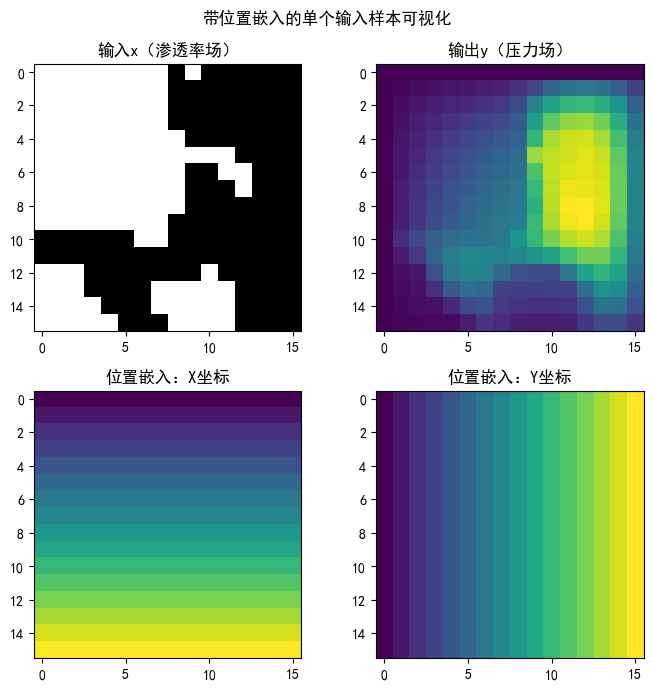

In [10]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

# 创建绘图画布（尺寸7x7英寸）
fig = plt.figure(figsize=(7, 7))

# 子图1：原始输入数据（渗透率场）
ax = fig.add_subplot(2, 2, 1)  # 2行2列的第1个位置
ax.imshow(x[0], cmap="gray")   # 绘制第0通道（原始输入）
ax.set_title("输入x（渗透率场）")  # 设置子图标题

# 子图2：输出数据（压力场）
ax = fig.add_subplot(2, 2, 2)  # 2行2列的第2个位置
ax.imshow(y.squeeze())         # squeeze()去掉多余维度，绘制输出
ax.set_title("输出y（压力场）")   # 设置子图标题

# 子图3：位置嵌入的X坐标通道
ax = fig.add_subplot(2, 2, 3)  # 2行2列的第3个位置
ax.imshow(x[1])                # 绘制第1通道（X坐标）
ax.set_title("位置嵌入：X坐标")  # 设置子图标题

# 子图4：位置嵌入的Y坐标通道
ax = fig.add_subplot(2, 2, 4)  # 2行2列的第4个位置
ax.imshow(x[2])                # 绘制第2通道（Y坐标）
ax.set_title("位置嵌入：Y坐标")  # 设置子图标题

# 设置总标题（y=0.98调整标题位置，避免遮挡）
fig.suptitle("带位置嵌入的单个输入样本可视化", y=0.98)
# 自动调整子图间距，避免重叠
plt.tight_layout()
# 显示图像
fig.show()

## 三维可视化输入数据与位置嵌入
除了2D热力图，我们还可以通过3D表面图更直观地观察输入数据和位置嵌入的空间分布，
理解每个维度在空间上的数值变化规律。

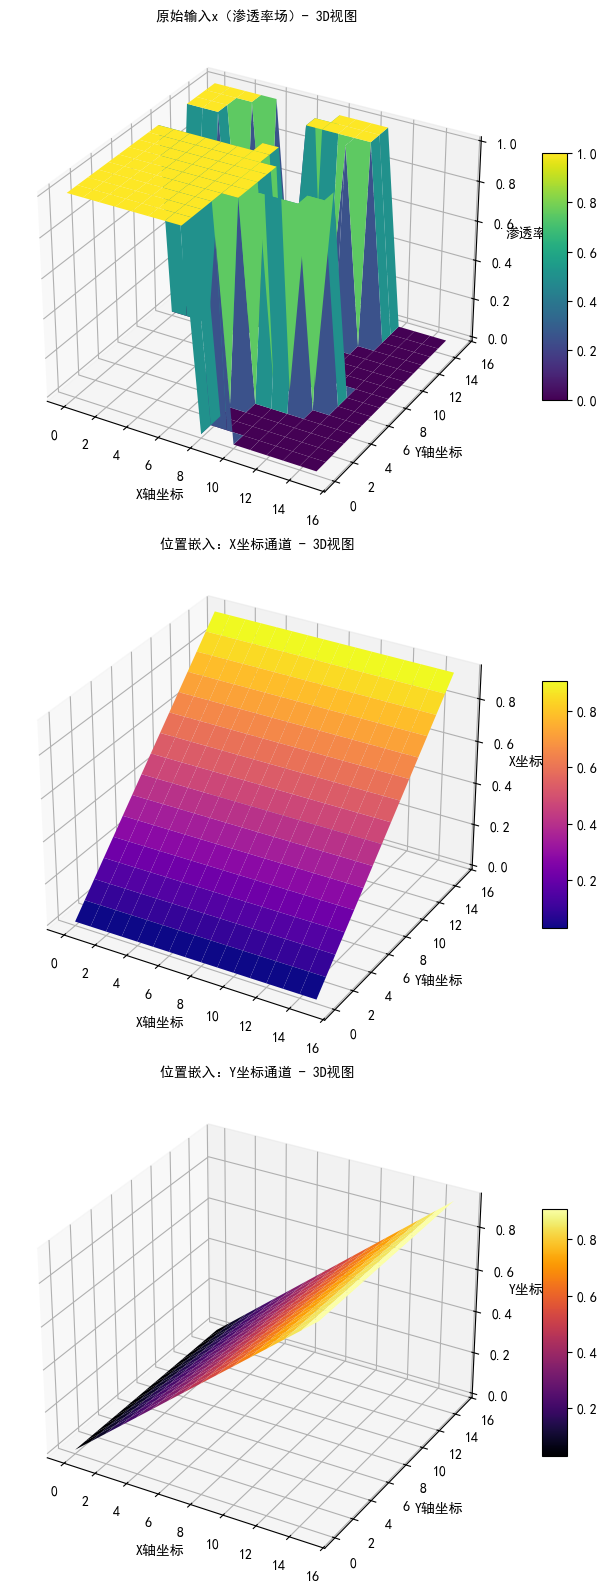

In [11]:

import numpy as np  # 导入numpy用于生成网格坐标
from mpl_toolkits.mplot3d import Axes3D  # 导入3D绘图工具

# 获取数据的分辨率（16x16，对应网格的行列数）
resolution = x[0].shape[0]
# 生成网格坐标：创建16x16的二维网格（对应x轴和y轴的坐标）
# np.arange(resolution)生成0到15的序列，meshgrid转为网格矩阵
x_coords, y_coords = np.meshgrid(np.arange(resolution), np.arange(resolution))

# 创建3D绘图画布（尺寸15x5英寸，适配3个子图）
fig = plt.figure(figsize=(8, 16))

# ========== 子图1：原始输入数据（渗透率场）的3D表面图 ==========
ax1 = fig.add_subplot(3, 1, 1, projection='3d')  # 3行1列第1个位置，3D投影
# 绘制3D表面图：x_coords/y_coords为平面坐标，x[0]为对应位置的数值（渗透率）
# cmap='viridis'为配色方案，linewidth=0消除网格线，antialiased=True抗锯齿
surf1 = ax1.plot_surface(x_coords, y_coords, x[0], cmap='viridis', 
                         linewidth=0, antialiased=True)
ax1.set_title("原始输入x（渗透率场）- 3D视图", fontsize=10)
ax1.set_xlabel("X轴坐标")
ax1.set_ylabel("Y轴坐标")
ax1.set_zlabel("渗透率值")
# 添加颜色条（映射数值与颜色）
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# ========== 子图2：位置嵌入x坐标通道的3D表面图 ==========
ax2 = fig.add_subplot(3, 1, 2, projection='3d')  # 3行1列第2个位置，3D投影
surf2 = ax2.plot_surface(x_coords, y_coords, x[1], cmap='plasma', 
                         linewidth=0, antialiased=True)
ax2.set_title("位置嵌入：X坐标通道 - 3D视图", fontsize=10)
ax2.set_xlabel("X轴坐标")
ax2.set_ylabel("Y轴坐标")
ax2.set_zlabel("X坐标值")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

# ========== 子图3：位置嵌入y坐标通道的3D表面图 ==========
ax3 = fig.add_subplot(3, 1, 3, projection='3d')  # 3行1列第3个位置，3D投影
surf3 = ax3.plot_surface(x_coords, y_coords, x[2], cmap='inferno', 
                         linewidth=0, antialiased=True)
ax3.set_title("位置嵌入：Y坐标通道 - 3D视图", fontsize=10)
ax3.set_xlabel("X轴坐标")
ax3.set_ylabel("Y轴坐标")
ax3.set_zlabel("Y坐标值")
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

# 调整子图间距，避免重叠
plt.tight_layout()
# 显示3D图像
plt.show()